<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/tc_practice/blob/main/06_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jjerry-k/tc_practice/blob/main/06_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Deep Convolutional Generative Adversarial Network

In [8]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [9]:
EPOCHS = 100
LATENT_SIZE = 16
BATCH_SIZE = 64
LEARNING_RATE = 0.0002

# Prepare dataset

In [10]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model

In [11]:
# our model
class Generator(nn.Module):
    def __init__(self, img_dim=[1,28,28], z_dim=100, gf_dim=64):
        super(Generator, self).__init__() 
        self.img_dim = img_dim
        self.z_dim = z_dim
        self.gf_dim = gf_dim
        self.s, self.s4, self.s8 = img_dim[-1], img_dim[-1]//4, img_dim[-1]//8
        
        self.linear = nn.Linear(z_dim, gf_dim*self.s8*self.s8)
        self.bn1 = nn.BatchNorm2d(gf_dim)

        self.deconv1 = nn.ConvTranspose2d(gf_dim, gf_dim//2, 5, 1, 0)
        self.bn2 = nn.BatchNorm2d(gf_dim//2)
        
        self.deconv2 = nn.ConvTranspose2d(gf_dim//2, gf_dim//4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(gf_dim//4)
        
        self.deconv3 = nn.ConvTranspose2d(gf_dim//4, 1, 4, 2, 1)
        
                    
    def forward(self, X):
        X = self.linear(X)
        X = self.bn1(X.reshape(-1, self.gf_dim, self.s8, self.s8))
        X = torch.relu(self.bn2(self.deconv1(X)))
        X = torch.relu(self.bn3(self.deconv2(X)))
        X = torch.tanh(self.deconv3(X))
        return X

class Discriminator(nn.Module):
    def __init__(self, img_dim=[1,28,28], df_dim=64):

        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(img_dim[0], df_dim//4, 5, 2, 2)
        
        self.conv2 = nn.Conv2d(df_dim//4, df_dim//2, 5, 2, 2)
        
        self.conv3 = nn.Conv2d(df_dim//2, df_dim, 5, 2, 2)
        
        pooled_size = (img_dim[-1]//8) + 1
        self.dense = nn.Linear(df_dim*pooled_size*pooled_size, 1)

    def forward(self, X):
        X = F.leaky_relu(self.conv1(X), negative_slope=0.003)
        X = F.leaky_relu(self.conv2(X), negative_slope=0.003)
        X = F.leaky_relu(self.conv3(X), negative_slope=0.003)
        X = X.reshape(X.size(0), -1)
        X = torch.sigmoid(self.dense(X))
        return X

G = Generator(z_dim=LATENT_SIZE).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE)

# Calculate Parameters

In [12]:
G_params = 0
for param_name, param in G.named_parameters():
    if param.requires_grad:
        G_params += len(param.reshape(-1))
print(f"Number of Generator's Parameters: {G_params:,d}")

D_params = 0
for param_name, param in D.named_parameters():
    if param.requires_grad:
        D_params += len(param.reshape(-1))
print(f"Number of Discriminator's Parameters: {D_params:,d}")

Number of Generator's Parameters: 69,713
Number of Discriminator's Parameters: 65,537


# Define help function

In [13]:
def plot_generator(gen_model, num = 10, latent_size=100):
    z = torch.normal(0, 1, (num, latent_size)).to(device)
    
    gen_model.eval()
    test_g = gen_model.forward(z)
    gen_model.train()

    plt.figure(figsize=(8, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(test_g[i].view(28, 28).data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()

# Train model 

Start training !
Epoch: 1, G_loss: 0.04616735875606537, D_loss: 0.002100120997056365
Epoch: 2, G_loss: 0.048626650124788284, D_loss: 0.0018562771147117019
Epoch: 3, G_loss: 0.0586739145219326, D_loss: 0.0010251812636852264
Epoch: 4, G_loss: 0.06375604122877121, D_loss: 0.0007801540195941925
Epoch: 5, G_loss: 0.07142682373523712, D_loss: 0.0005871787434443831


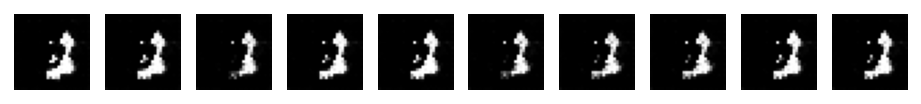

Epoch: 6, G_loss: 0.08037467300891876, D_loss: 0.0005132162477821112
Epoch: 7, G_loss: 0.07596798241138458, D_loss: 0.000986499828286469
Epoch: 8, G_loss: 0.05513894185423851, D_loss: 0.0021836624946445227
Epoch: 9, G_loss: 0.046522367745637894, D_loss: 0.003325759433209896
Epoch: 10, G_loss: 0.03519710898399353, D_loss: 0.004470329266041517


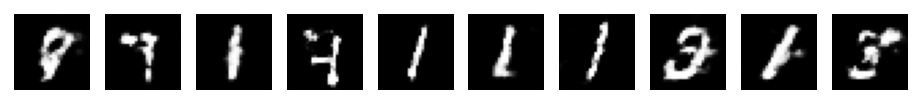

Epoch: 11, G_loss: 0.029822641983628273, D_loss: 0.005459647625684738
Epoch: 12, G_loss: 0.027142783626914024, D_loss: 0.005818462464958429
Epoch: 13, G_loss: 0.027014154940843582, D_loss: 0.006201181095093489
Epoch: 14, G_loss: 0.0259137861430645, D_loss: 0.006315779406577349
Epoch: 15, G_loss: 0.02550976164638996, D_loss: 0.006492494139820337


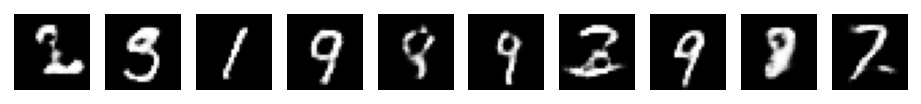

Epoch: 16, G_loss: 0.025554567575454712, D_loss: 0.006534157786518335
Epoch: 17, G_loss: 0.02424393594264984, D_loss: 0.006597201805561781
Epoch: 18, G_loss: 0.02433435618877411, D_loss: 0.0065619791857898235
Epoch: 19, G_loss: 0.024973630905151367, D_loss: 0.006680910941213369
Epoch: 20, G_loss: 0.02407732419669628, D_loss: 0.006641381420195103


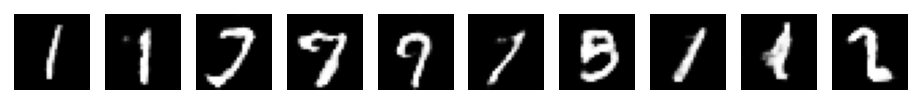

Epoch: 21, G_loss: 0.02421668916940689, D_loss: 0.006617754697799683
Epoch: 22, G_loss: 0.02510826848447323, D_loss: 0.006701878271996975
Epoch: 23, G_loss: 0.024005914106965065, D_loss: 0.006577278021723032
Epoch: 24, G_loss: 0.02423572912812233, D_loss: 0.00662107253447175
Epoch: 25, G_loss: 0.02518320456147194, D_loss: 0.006624664179980755


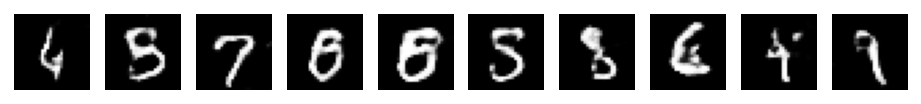

Epoch: 26, G_loss: 0.02431827038526535, D_loss: 0.0065425485372543335
Epoch: 27, G_loss: 0.02431509830057621, D_loss: 0.006549375131726265
Epoch: 28, G_loss: 0.02504023350775242, D_loss: 0.006514574866741896
Epoch: 29, G_loss: 0.024886826053261757, D_loss: 0.006514510605484247
Epoch: 30, G_loss: 0.024683762341737747, D_loss: 0.006408448796719313


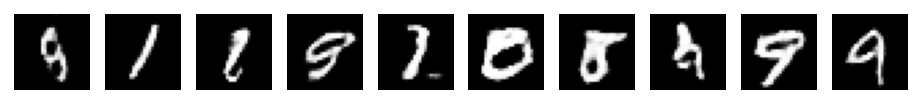

Epoch: 31, G_loss: 0.025012923404574394, D_loss: 0.00641022901982069
Epoch: 32, G_loss: 0.02530582994222641, D_loss: 0.00632747495546937
Epoch: 33, G_loss: 0.02528214454650879, D_loss: 0.006279592867940664
Epoch: 34, G_loss: 0.0255703367292881, D_loss: 0.0062447963282465935
Epoch: 35, G_loss: 0.025742121040821075, D_loss: 0.006159759592264891


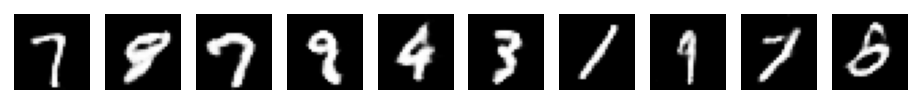

Epoch: 36, G_loss: 0.026133036240935326, D_loss: 0.006123281549662352
Epoch: 37, G_loss: 0.026037881150841713, D_loss: 0.00613988796249032
Epoch: 38, G_loss: 0.026184048503637314, D_loss: 0.006062510889023542
Epoch: 39, G_loss: 0.02614964358508587, D_loss: 0.006000325549393892
Epoch: 40, G_loss: 0.026735778898000717, D_loss: 0.005959971342235804


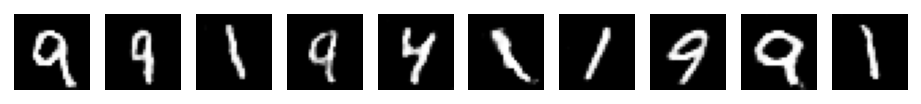

Epoch: 41, G_loss: 0.026863858103752136, D_loss: 0.0058791982010006905
Epoch: 42, G_loss: 0.026987183839082718, D_loss: 0.005837136879563332
Epoch: 43, G_loss: 0.02759537100791931, D_loss: 0.005787096917629242
Epoch: 44, G_loss: 0.027587266638875008, D_loss: 0.0056993733160197735
Epoch: 45, G_loss: 0.027870554476976395, D_loss: 0.005709089804440737


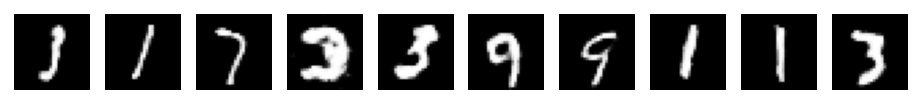

Epoch: 46, G_loss: 0.02800895646214485, D_loss: 0.0056625776924192905
Epoch: 47, G_loss: 0.028167854994535446, D_loss: 0.0056017013266682625
Epoch: 48, G_loss: 0.02836647816002369, D_loss: 0.0055372933857142925
Epoch: 49, G_loss: 0.028350170701742172, D_loss: 0.005521179176867008
Epoch: 50, G_loss: 0.02885037660598755, D_loss: 0.005449826829135418


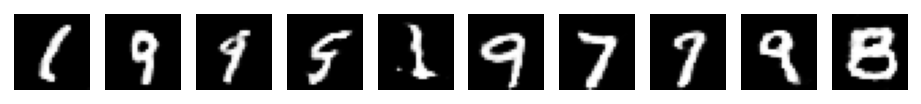

Epoch: 51, G_loss: 0.029323602095246315, D_loss: 0.005365400109440088
Epoch: 52, G_loss: 0.029376577585935593, D_loss: 0.00536916172131896
Epoch: 53, G_loss: 0.029455730691552162, D_loss: 0.005284751765429974
Epoch: 54, G_loss: 0.029712991788983345, D_loss: 0.005219436250627041
Epoch: 55, G_loss: 0.030097058042883873, D_loss: 0.0051564243622124195


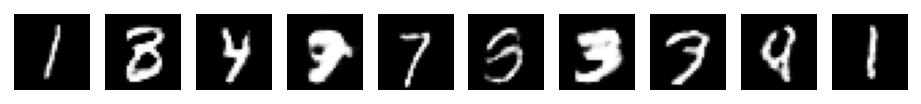

Epoch: 56, G_loss: 0.03036835975944996, D_loss: 0.005125686060637236
Epoch: 57, G_loss: 0.03039952553808689, D_loss: 0.005106622353196144
Epoch: 58, G_loss: 0.03067139722406864, D_loss: 0.005070177838206291
Epoch: 59, G_loss: 0.030904635787010193, D_loss: 0.005004336126148701
Epoch: 60, G_loss: 0.031201902776956558, D_loss: 0.005004584789276123


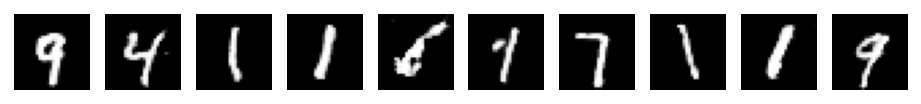

Epoch: 61, G_loss: 0.0311751626431942, D_loss: 0.0049285441637039185
Epoch: 62, G_loss: 0.03152709826827049, D_loss: 0.004885203205049038
Epoch: 63, G_loss: 0.031742364168167114, D_loss: 0.00487917847931385
Epoch: 64, G_loss: 0.031842850148677826, D_loss: 0.004757217597216368
Epoch: 65, G_loss: 0.03246048465371132, D_loss: 0.0047283233143389225


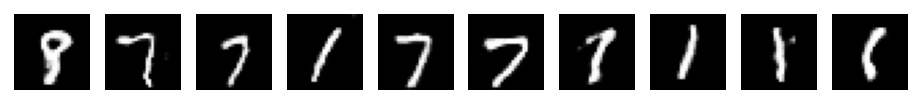

Epoch: 66, G_loss: 0.03231207653880119, D_loss: 0.0046936203725636005
Epoch: 67, G_loss: 0.0326203890144825, D_loss: 0.0046140472404658794
Epoch: 68, G_loss: 0.03310438618063927, D_loss: 0.004611812066286802
Epoch: 69, G_loss: 0.03328948840498924, D_loss: 0.004538512323051691
Epoch: 70, G_loss: 0.033250726759433746, D_loss: 0.0045079076662659645


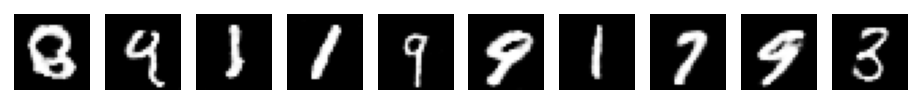

Epoch: 71, G_loss: 0.03350609540939331, D_loss: 0.004462466575205326
Epoch: 72, G_loss: 0.0336938239634037, D_loss: 0.004478271119296551
Epoch: 73, G_loss: 0.0337764210999012, D_loss: 0.004405116196721792
Epoch: 74, G_loss: 0.034266456961631775, D_loss: 0.004334877245128155
Epoch: 75, G_loss: 0.03419146314263344, D_loss: 0.004345453344285488


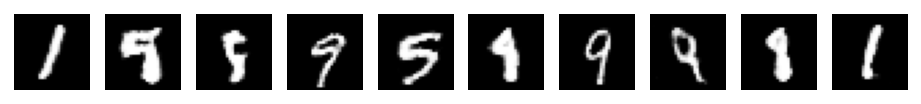

Epoch: 76, G_loss: 0.034508202224969864, D_loss: 0.004306842107325792
Epoch: 77, G_loss: 0.03452330827713013, D_loss: 0.004246674478054047
Epoch: 78, G_loss: 0.03466559946537018, D_loss: 0.004227563738822937
Epoch: 79, G_loss: 0.035229478031396866, D_loss: 0.004144666716456413
Epoch: 80, G_loss: 0.03519902750849724, D_loss: 0.004113239236176014


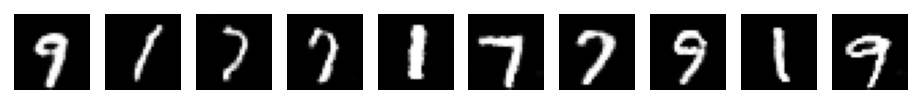

Epoch: 81, G_loss: 0.03572530671954155, D_loss: 0.004124497063457966
Epoch: 82, G_loss: 0.03551706299185753, D_loss: 0.004039186052978039
Epoch: 83, G_loss: 0.035770706832408905, D_loss: 0.004021130967885256
Epoch: 84, G_loss: 0.03580738231539726, D_loss: 0.004007113166153431
Epoch: 85, G_loss: 0.03591823950409889, D_loss: 0.0039752572774887085


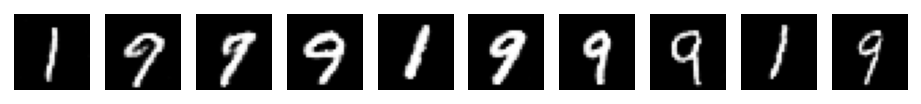

Epoch: 86, G_loss: 0.036106761544942856, D_loss: 0.00394767802208662
Epoch: 87, G_loss: 0.03623669221997261, D_loss: 0.003898395225405693
Epoch: 88, G_loss: 0.03644920513033867, D_loss: 0.0038920575752854347
Epoch: 89, G_loss: 0.036652736365795135, D_loss: 0.003871453693136573
Epoch: 90, G_loss: 0.036932479590177536, D_loss: 0.003796693403273821


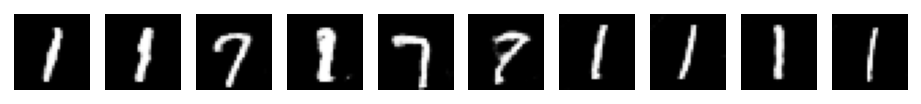

Epoch: 91, G_loss: 0.037294115871191025, D_loss: 0.0038021805230528116
Epoch: 92, G_loss: 0.03735809028148651, D_loss: 0.003758871229365468
Epoch: 93, G_loss: 0.03735319897532463, D_loss: 0.0037191822193562984
Epoch: 94, G_loss: 0.03760553523898125, D_loss: 0.003721182234585285
Epoch: 95, G_loss: 0.03766833618283272, D_loss: 0.0036898127291351557


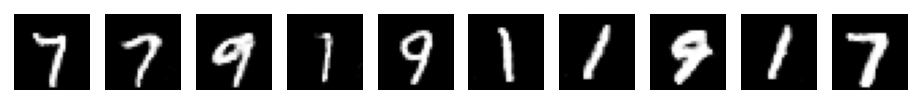

Epoch: 96, G_loss: 0.038005486130714417, D_loss: 0.003656618529930711
Epoch: 97, G_loss: 0.03806905820965767, D_loss: 0.003611871739849448
Epoch: 98, G_loss: 0.03836575523018837, D_loss: 0.0036280048079788685
Epoch: 99, G_loss: 0.038565412163734436, D_loss: 0.0035643812734633684


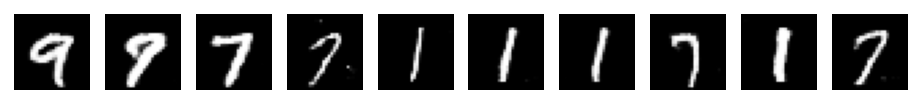

Epoch: 100, G_loss: 0.038711871951818466, D_loss: 0.0035228431224823


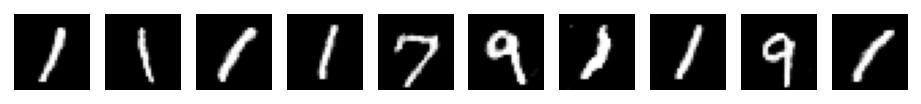

Training Done !


In [14]:
# Training Phase
print_every = 1
plot_every = 5
print("Start training !")

# Training loop
for epoch in range(EPOCHS):
    total = 0
    g_loss_val_sum = 0
    d_loss_val_sum = 0
    for batch_img, _ in train_iter:

        X = batch_img.to(device)

        real_lab = torch.ones(batch_img.size(0), 1).to(device)
        
        fake_lab = torch.zeros(batch_img.size(0), 1).to(device)
        
        # Training Discriminator
        D_pred = D.forward(X)
        d_loss_real = criterion(D_pred, real_lab)
        
        z = torch.normal(0, 1, (batch_img.size(0), LATENT_SIZE)).to(device)
        
        fake_images = G.forward(z)
        G_pred = D.forward(fake_images)
        d_loss_fake = criterion(G_pred, fake_lab)
        
        d_loss = (d_loss_real + d_loss_fake)/2.
        d_loss_val_sum += d_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        # Training Generator
        z = torch.normal(0, 1, (batch_img.size(0), LATENT_SIZE)).to(device)
        fake_images = G.forward(z)
        G_pred = D.forward(fake_images)
        g_loss = criterion(G_pred, real_lab)
        g_loss_val_sum += g_loss

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        total += X.size(0)
        
    if (((epoch+1)%print_every)==0) or ((epoch+1)==(EPOCHS-1)):
            print(f"Epoch: {epoch+1}, G_loss: {g_loss_val_sum/total}, D_loss: {d_loss_val_sum/total}")
    if (((epoch+1)%plot_every)==0) or ((epoch+1)==(EPOCHS-1)):
        plot_generator(G, num = 10, latent_size=LATENT_SIZE)
print("Training Done !")